In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
#Read data from google drive
df = pd.read_csv("/content/drive/MyDrive/dataset_mood_smartphone.csv", parse_dates=['time'])
df

,Unnamed: 0,id,time,variable,value
0,1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
1,2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
2,3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
3,4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
4,5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...,...
376907,2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
376908,2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
376909,2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
376910,2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


In [ ]:
# Droppping Unrequired/unrelated column "Unnamed: 0"
df = df.drop('Unnamed: 0', axis=1)
df.head()

,id,time,variable,value
0,AS14.01,2014-02-26 13:00:00,mood,6.0
1,AS14.01,2014-02-26 15:00:00,mood,6.0
2,AS14.01,2014-02-26 18:00:00,mood,6.0
3,AS14.01,2014-02-26 21:00:00,mood,7.0
4,AS14.01,2014-02-27 09:00:00,mood,6.0


In [ ]:
df = df.sort_values(by=['id', 'time'])
df

,id,time,variable,value
136470,AS14.01,2014-02-17 12:04:42.394,call,1.000
136471,AS14.01,2014-02-17 18:28:25.520,call,1.000
136472,AS14.01,2014-02-18 09:29:51.257,call,1.000
136473,AS14.01,2014-02-19 14:43:30.575,call,1.000
136474,AS14.01,2014-02-19 17:29:10.378,call,1.000
...,...,...,...,...
234793,AS14.33,2014-05-30 22:32:14.240,appCat.builtin,1.003
234794,AS14.33,2014-05-30 22:32:15.246,appCat.builtin,4.134
5640,AS14.33,2014-05-31 12:00:00.000,mood,7.000
11283,AS14.33,2014-05-31 12:00:00.000,circumplex.arousal,-2.000


In [ ]:
# Extract date from timestamp
df['date'] = df['time'].dt.date
df

,id,time,variable,value,date
136470,AS14.01,2014-02-17 12:04:42.394,call,1.000,2014-02-17
136471,AS14.01,2014-02-17 18:28:25.520,call,1.000,2014-02-17
136472,AS14.01,2014-02-18 09:29:51.257,call,1.000,2014-02-18
136473,AS14.01,2014-02-19 14:43:30.575,call,1.000,2014-02-19
136474,AS14.01,2014-02-19 17:29:10.378,call,1.000,2014-02-19
...,...,...,...,...,...
234793,AS14.33,2014-05-30 22:32:14.240,appCat.builtin,1.003,2014-05-30
234794,AS14.33,2014-05-30 22:32:15.246,appCat.builtin,4.134,2014-05-30
5640,AS14.33,2014-05-31 12:00:00.000,mood,7.000,2014-05-31
11283,AS14.33,2014-05-31 12:00:00.000,circumplex.arousal,-2.000,2014-05-31


In [ ]:
# Pivot to wide format (one row per ID-date with variables as columns, day-level aggregation)
pivot_df = df.pivot_table(
    index=['id', 'date'],
    columns='variable',
    values='value'
).reset_index().fillna(0)
pivot_df

variable,id,date,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,AS14.01,2014-02-17,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0
1,AS14.01,2014-02-18,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0
2,AS14.01,2014-02-19,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0,0.000000,1.0
3,AS14.01,2014-02-20,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0,0.000000,1.0
4,AS14.01,2014-02-21,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,AS14.33,2014-05-27,0.012704,8.545776,59.382943,62.347000,0.0,0.0,0.000000,17.835750,...,0.000000,0.000000,18.724333,0.0,1.0,-0.600000,0.4,6.2,113.607750,1.0
1969,AS14.33,2014-05-28,0.103301,9.590398,37.238750,43.907571,0.0,0.0,44.738625,27.891895,...,0.000000,0.000000,5.111000,0.0,1.0,0.000000,1.2,8.2,113.657683,1.0
1970,AS14.33,2014-05-29,0.169354,6.452161,54.388125,68.369000,0.0,0.0,0.000000,9.734000,...,0.939000,0.000000,1.599500,0.0,1.0,-1.333333,1.0,7.0,118.978033,1.0
1971,AS14.33,2014-05-30,0.192901,14.776845,46.412278,37.174286,0.0,0.0,0.000000,10.522000,...,37.594571,2.690667,15.521667,0.0,1.0,-0.800000,-0.4,6.8,86.342245,0.0


In [ ]:
# Forward fill missing values (within each ID's data)
pivot_df['date'] = pivot_df['date'].apply(lambda date: date.toordinal())

In [ ]:
# Add all variables
expected_vars = [
    'mood', 'circumplex.arousal', 'circumplex.valence', 'activity',
    'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
    'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office',
    'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown',
    'appCat.utilities', 'appCat.weather'
]

#filling any missing variable values with 0
for var in expected_vars:
    if var not in pivot_df.columns:
        pivot_df[var] = 0

In [ ]:
# Create target (next day's mood)
pivot_df['target_mood'] = pivot_df.groupby('id')['mood'].shift(-1)
pivot_df = pivot_df.dropna(subset=['target_mood'])

In [ ]:
# Define mood classes: bad (1-3), normal (4-7), good (8-10)
pivot_df['mood_class'] = pd.cut(pivot_df['target_mood'],
                                bins=[0, 3, 7, 10],
                                labels=['bad', 'normal', 'good'],
                                include_lowest=True,
                                right=False)
#pivot_df = pivot_df.dropna(subset=['mood_class'])

<ipython-input-12-999d892932ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_df['mood_class'] = pd.cut(pivot_df['target_mood'],


In [ ]:
print(pivot_df['mood_class'].nunique())

3


In [ ]:
# Encode labels
le = LabelEncoder()
pivot_df['mood_class_encoded'] = le.fit_transform(pivot_df['mood_class'])

<ipython-input-14-a9c539d3b0c7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_df['mood_class_encoded'] = le.fit_transform(pivot_df['mood_class'])


In [ ]:
print(pivot_df['mood_class_encoded'].nunique())

3


In [ ]:
pivot_df

variable,id,date,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms,target_mood,mood_class,mood_class_encoded
0,AS14.01,735281,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,bad,0
1,AS14.01,735282,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,bad,0
2,AS14.01,735283,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,1.0,0.000000,0.0,0.0,0.000000,1.0,0.0,bad,0
3,AS14.01,735284,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,1.0,0.000000,0.0,0.0,0.000000,1.0,0.0,bad,0
4,AS14.01,735285,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,bad,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,AS14.33,735379,0.115201,7.711316,34.320472,68.876900,0.0,0.0,130.530000,16.845500,...,0.0,1.0,-0.400000,0.0,5.4,300.399810,1.0,6.2,normal,2
1968,AS14.33,735380,0.012704,8.545776,59.382943,62.347000,0.0,0.0,0.000000,17.835750,...,0.0,1.0,-0.600000,0.4,6.2,113.607750,1.0,8.2,good,1
1969,AS14.33,735381,0.103301,9.590398,37.238750,43.907571,0.0,0.0,44.738625,27.891895,...,0.0,1.0,0.000000,1.2,8.2,113.657683,1.0,7.0,good,1
1970,AS14.33,735382,0.169354,6.452161,54.388125,68.369000,0.0,0.0,0.000000,9.734000,...,0.0,1.0,-1.333333,1.0,7.0,118.978033,1.0,6.8,normal,2


## Normalizing

In [ ]:
# Select features and target
features = [col for col in pivot_df.columns if col not in
           ['id', 'day', 'mood', 'target_mood', 'mood_class', 'mood_class_encoded']]
scaler = MinMaxScaler()
pivot_df[features] = scaler.fit_transform(pivot_df[features])

<ipython-input-17-6a0e2da6f8b5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_df[features] = scaler.fit_transform(pivot_df[features])


##Creating sequences

In [ ]:
#sequence of previous 7 days
def create_sequences(data, seq_length=7):
    sequences = []
    targets = []
    for user in data['id'].unique():
        user_data = data[data['id'] == user]
        user_data = user_data.sort_values('date')
        for i in range(len(user_data) - seq_length):
            seq = user_data.iloc[i:i+seq_length][features].values
            label = user_data.iloc[i+seq_length]['mood_class_encoded']
            sequences.append(seq)
            targets.append(label)
    return np.array(sequences), np.array(targets)

X, y = create_sequences(pivot_df, seq_length=7)
y = to_categorical(y)  # Convert to one-hot encoding

In [ ]:
#Train test spilt
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False)

##Building LSTM model

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Training the model for 20 epochs
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4495 - loss: 1.0283 - val_accuracy: 0.7812 - val_loss: 0.7392
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5777 - loss: 0.7897 - val_accuracy: 0.7330 - val_loss: 0.6968
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6130 - loss: 0.7411 - val_accuracy: 0.7812 - val_loss: 0.6728
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6232 - loss: 0.7316 - val_accuracy: 0.7045 - val_loss: 0.8000
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6169 - loss: 0.7381 - val_accuracy: 0.7614 - val_loss: 0.7243
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6265 - loss: 0.7304 - val_accuracy: 0.6847 - val_loss: 0.8185
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6425 - loss: 0.7029 - val_accuracy: 0.7074 - val_loss: 0.7027
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6248 - loss: 0.7198 - val_accuracy: 0.7330 - v

In [ ]:
model.fit(X_train,y_train)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6796 - loss: 0.6370


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7915 - loss: 0.6131 
Test Accuracy: 73.30%


##Prediction

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


In [ ]:
# Classification report
print(classification_report(
    y_test_classes,
    y_pred_classes,
    target_names=le.classes_  # ['bad', 'normal', 'good']
))

              precision    recall  f1-score   support

         bad       0.97      0.71      0.82       140
        good       0.68      0.94      0.79       166
      normal       0.16      0.07      0.09        46

    accuracy                           0.73       352
   macro avg       0.60      0.57      0.57       352
weighted avg       0.73      0.73      0.71       352



##Evalutaion

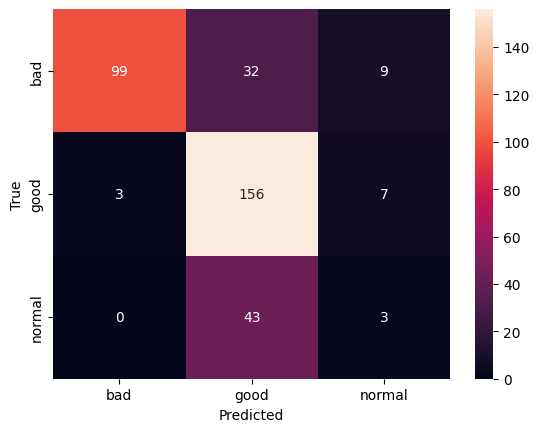

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Split data chronologically (no shuffling)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

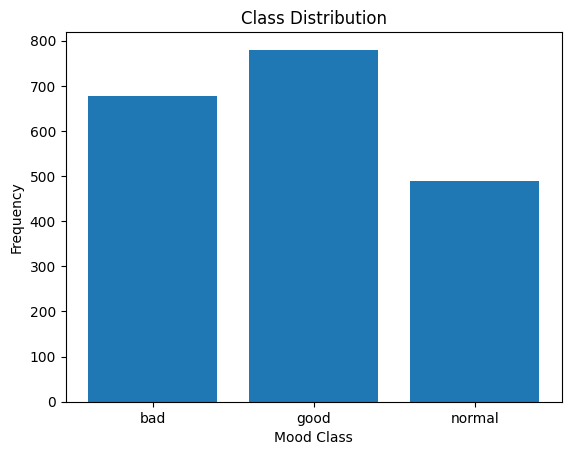

In [ ]:
plt.bar(le.classes_, np.bincount(pivot_df['mood_class_encoded']))
plt.title('Class Distribution')
plt.xlabel('Mood Class')
plt.ylabel('Frequency')
plt.show()

ROC-AUC (OvR): 0.857


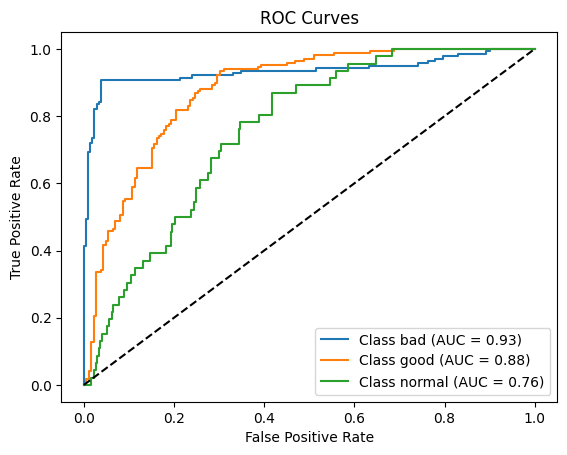

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate AUC (One-vs-Rest)
auc_ovr = roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f"ROC-AUC (OvR): {auc_ovr:.3f}")

# Plot ROC curves for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i]) # using roc_auc_score to calculate auc for each class

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

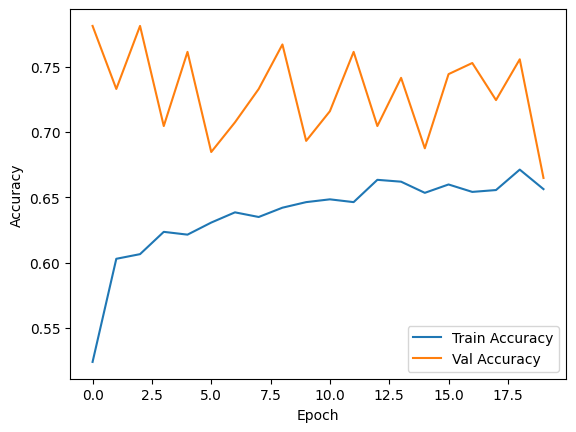

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test_classes, y_pred_classes)
print(f"Cohen’s Kappa: {kappa:.3f}")

Cohen’s Kappa: 0.530


##Hyperparameter tuning

In [ ]:
pip install keras-tuner

In [ ]:
from tensorflow import keras
from keras_tuner import HyperModel, RandomSearch

class LSTMTuner(HyperModel):
    def build(self, hp):
        model = keras.Sequential()

        # Tunable LSTM layers
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(
                keras.layers.LSTM(
                    units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=256, step=32),
                    return_sequences=(i < hp.get('num_layers') - 1)  # Only last layer returns sequences=False
                )
            )
            model.add(keras.layers.Dropout(
                hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)
            ))

        # Tunable dense layers
        model.add(keras.layers.Dense(
            units=hp.Int('dense_units', 16, 128, step=16),
            activation='relu'
        ))
        model.add(keras.layers.Dense(3, activation='softmax'))

        # Tunable learning rate
        learning_rate = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [ ]:
hypermodel = LSTMTuner()

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=20,  # Adjust based on compute resources
    executions_per_trial=2,  # Reduce variance by averaging multiple runs
    directory='lstm_tuning',
    project_name='mood_prediction'
)

In [ ]:
tuner.search(
    X_train, y_train,
    epochs=30,
    batch_size=32,  # Include batch size in search space
    validation_data=(X_test, y_test),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    ]
)

Trial 20 Complete [00h 00m 27s]
val_accuracy: 0.7982954680919647

Best val_accuracy So Far: 0.8096590936183929
Total elapsed time: 00h 14m 32s


In [ ]:
# Get the best hyperparameters from the tuner
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[keras.callbacks.EarlyStopping(patience=5)]
)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 0.4758 - loss: 1.0080 - val_accuracy: 0.6591 - val_loss: 0.8420
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.5869 - loss: 0.7461 - val_accuracy: 0.7812 - val_loss: 0.6528
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6546 - loss: 0.7250 - val_accuracy: 0.8097 - val_loss: 0.6714
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.6366 - loss: 0.6952 - val_accuracy: 0.8068 - val_loss: 0.5974
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.6450 - loss: 0.6952 - val_accuracy: 0.8153 - val_loss: 0.6005
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.6425 - loss: 0.6915 - val_accuracy: 0.8097 - val_loss: 0.6071
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.6508 - loss: 0.6639 - val_accuracy: 0.8097 - val_loss: 0.6030
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.6350 - loss: 0.6942 - val_accura

In [ ]:
# Predict classes
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [ ]:
# Classification report
print(classification_report(
    y_test_classes,
    y_pred_classes,
    target_names=le.classes_  # ['bad', 'normal', 'good']
))

              precision    recall  f1-score   support

         bad       0.93      0.87      0.90       140
        good       0.71      0.95      0.82       166
      normal       0.00      0.00      0.00        46

    accuracy                           0.80       352
   macro avg       0.55      0.61      0.57       352
weighted avg       0.71      0.80      0.74       352



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC-AUC (OvR): 0.828


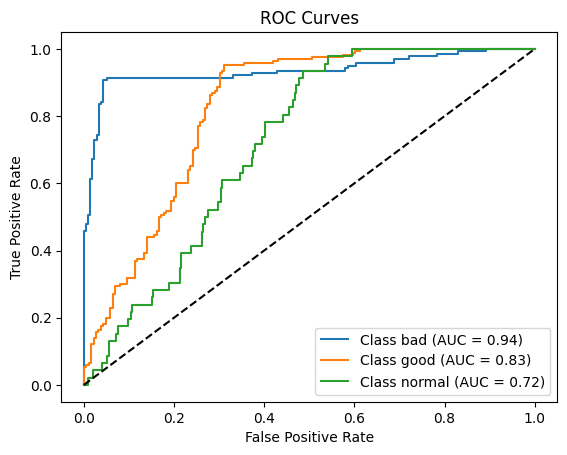

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate AUC (One-vs-Rest)
auc_ovr = roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f"ROC-AUC (OvR): {auc_ovr:.3f}")

# Plot ROC curves for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i]) # using roc_auc_score to calculate auc for each class

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

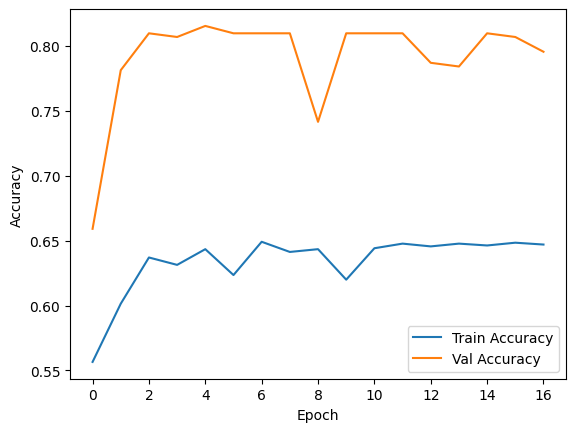

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test_classes, y_pred_classes)
print(f"Cohen’s Kappa: {kappa:.3f}")

Cohen’s Kappa: 0.632
